**To begin with we install our yfinance library and import some other libraries to help us out**

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from datetime import date
from datetime import timedelta

In [2]:

slider=widgets.IntSlider(min=2000, max=2020, step=1, value = 2010)
display(slider)
button1 = widgets.Button(description='Get Data')
out = widgets.Output()
def download_data(_):
    with out:
        out.clear_output(wait=True)
        number = slider.value
        sp5 = yf.Ticker("SPY")
        global history 
        history = sp5.history(start=str(number) + "-01-01", end = date.today().strftime("%Y-%m-%d"))#end="2021-01-01")
        data = history['Close']
        print(type(data))
        data.plot(figsize=(16,9))
        plt.show()
#widgets.interact(download_data, number=slider)
button1.on_click(download_data)
widgets.VBox([button1,out])


IntSlider(value=2010, max=2020, min=2000)

In [7]:
slider_training_len=widgets.IntSlider(min=10, max=120, step=10, value = 10)
display(slider_training_len)
button2 = widgets.Button(description='Button')
out2 = widgets.Output()
def train_data(_):
    with out2:
        training_len = slider_training_len.value
        data = history.filter(['Close'])
        dataset = data.values
        training_data_len = math.ceil(len(dataset) *.8)
        scaler = MinMaxScaler(feature_range = (0,1))
        scaled_data = scaler.fit_transform(dataset)
        train_data = scaled_data[0: training_data_len, :]
        x_train = []
        y_train = []
        input_data_length = training_len
        for i in range(input_data_length, len(train_data)):
            x_train.append(train_data[i-input_data_length:i, 0])
            y_train.append(train_data[i,0])
        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
        model = Sequential()
        model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1],1)))
        #model.add(Dropout(.3))
        model.add(LSTM(64, return_sequences=False))
        #model.add(Dropout(.3))
        model.add(Dense(32))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(x_train,y_train,batch_size=64, epochs=5)
        test_data = scaled_data[training_data_len-input_data_length: , :]
        x_test = []
        y_test = dataset[training_data_len: , : ]
        for i in range(input_data_length,len(test_data)):
          x_test.append(test_data[i-input_data_length:i,0])
        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        predictions = model.predict(x_test)
        x = ['0-0.5%', '0.5-1%', '1-2%', '2-3%', '3-5%', '>5%']
        percentage = [0,0,0,0,0,0]
        for i in range(input_data_length,len(test_data)):
          if np.absolute(predictions[i - input_data_length]-test_data[i]) / test_data[i] * 100 < .5:
            percentage[0] += 1
          elif np.absolute(predictions[i - input_data_length]-test_data[i]) / test_data[i] * 100 < 1:
            percentage[1] += 1
          elif np.absolute(predictions[i - input_data_length]-test_data[i]) / test_data[i] * 100 < 2:
            percentage[2] += 1
          elif np.absolute(predictions[i - input_data_length]-test_data[i]) / test_data[i] * 100 < 3:
            percentage[3] += 1
          elif np.absolute(predictions[i - input_data_length]-test_data[i]) / test_data[i] * 100 < 5:
            percentage[4] += 1
          else:
            percentage[5] += 1
        #print(percentage)
        predictions = scaler.inverse_transform(predictions)
        #print(predictions)

        plt.figure(figsize=(20,12))
        plt.bar(x, percentage)
        plt.xlabel('Percent Error')
        plt.ylabel('Predictions')
        plt.title('Number of predictions by percent error')

        plt.show()
        rmse = np.sqrt(np.mean(predictions - y_test) **2)
        print(rmse)
        train = data[:training_data_len]
        valid = data[training_data_len:]
        valid['Predictions'] = predictions
        plt.figure(figsize=(20,12))
        plt.title('model')
        plt.xlabel('')
        plt.ylabel('')
        #plt.plot(train['Close'])
        plt.plot(valid[['Close', 'Predictions']])
        plt.legend(['Testing', 'Predictions'])
        plt.show()
button2.on_click(train_data)
widgets.VBox([button2,out2])

IntSlider(value=10, max=120, min=10, step=10)

**Here we will atempt to predict prices for 5 days after the specified date**

In [14]:
test_data = scaled_data[training_data_len-input_data_length: , :]
x_test = []
y_test = dataset[training_data_len: , : ]

In [15]:
slider_date=widgets.SelectionSlider(options=data['Close'][training_data_len:len(data)].keys())
display(slider_date)

SelectionSlider(options=(Timestamp('2019-06-19 00:00:00'), Timestamp('2019-06-20 00:00:00'), Timestamp('2019-0…

C:\Users\joe_b\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
<ipython-input-17-74c4ec8e42b6>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid2['Predictions'] = predictions5d['Close']


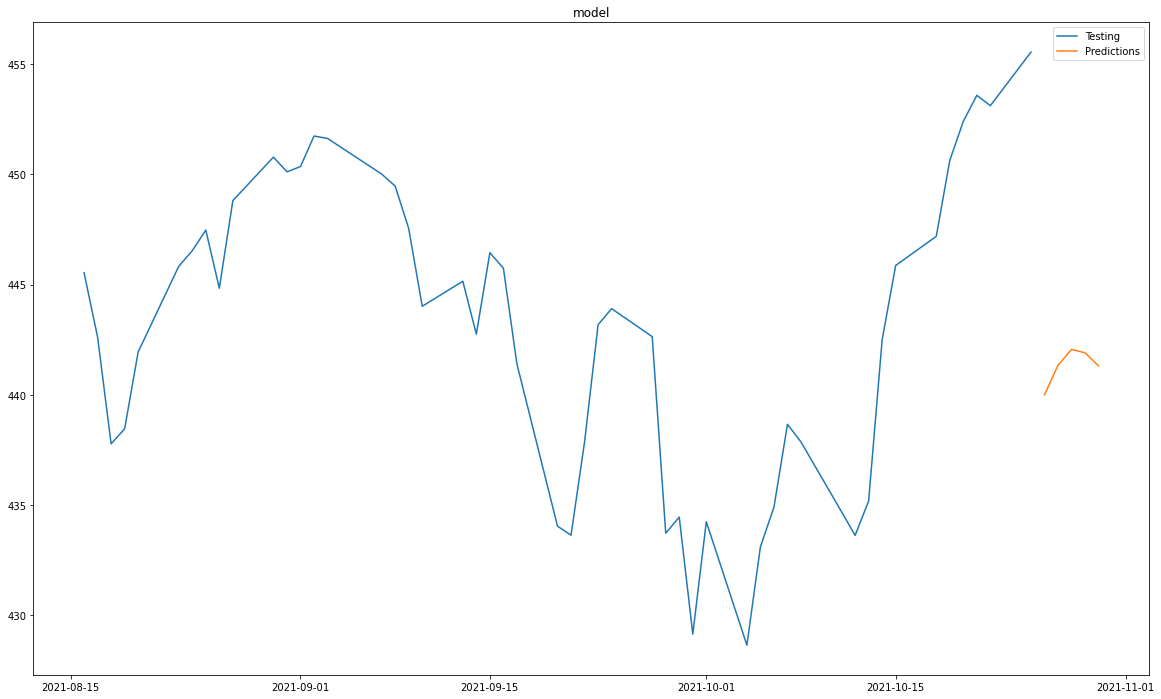

In [17]:
#set up predictions with dates
predictions5d = data[training_data_len:].copy()
prediction = []

#removes data from predictions leaving dates
for i in range(0,predictions5d.size):
  predictions5d['Close'][i] = None

start_pos = input_data_length + slider_date.index + 1
stop_pos = input_data_length + slider_date.index + 6
x_test =[]
x_test.append(test_data[start_pos - input_data_length:start_pos,0])

for i in range(input_data_length + slider_date.index + 1,input_data_length + slider_date.index + 6):
  x_test_data = x_test.copy()
  x_test_data = np.array(x_test_data)
  x_test_data = np.reshape(x_test_data, (x_test_data.shape[0], x_test_data.shape[1], 1))
  prediction.append(model.predict(x_test_data)[0])
  x_test[0] = x_test[0][1:]
  x_test[0] = np.append(x_test[0], model.predict(x_test_data)[0])

valid2 = data[training_data_len + start_pos - 50 - input_data_length:training_data_len + stop_pos - input_data_length]
prediction = scaler.inverse_transform(prediction)
for i in range(slider_date.index + 1,slider_date.index + 6):
  if(i>=predictions5d.size):
    predictions5d.loc[pd.to_datetime(predictions5d.index[i-1]) + timedelta(days=1)]= [None]
    valid2.loc[pd.to_datetime(predictions5d.index[i-1]) + timedelta(days=1)] = [None]
  predictions5d['Close'][i]=prediction[i-slider_date.index -1]


valid2['Predictions'] = predictions5d['Close']
plt.figure(figsize=(20,12))
plt.title('model')
plt.xlabel('')
plt.ylabel('')
plt.plot(valid2[['Close','Predictions']])
plt.legend(['Testing', 'Predictions'])